In [2]:
def find_best_k(X_train, y_train, K_s, metric, K_fold):
    best_k = None
    best_accuracy = 0
    # Acha melhor k para uma lista de Ks
    for k in K_s:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1)
        # Usa Cross-Validation
        start_time = time.time()
        scores = cross_val_score(knn, X_train, y_train, cv=K_fold, scoring='accuracy')
        end_time = time.time()
        # Pega o K com melhor acuracia
        mean_accuracy = np.mean(scores)
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_k = k

        # imprime scores
        print(f"Scores ---- métrica: {metric} ---- valor de k: {k}")
        print(f"Tempo total de execução: {end_time - start_time:.2f} segundos")
        print(f"Acurácia em cada uma das 5 dobras: {scores}")
        print(f"Acurácia Média: {mean_accuracy:.4f}")
        print(f"Desvio Padrão: {np.std(scores):.4f}\n")
    return best_k, best_accuracy

In [3]:
# Função para mostrar as imagens e as previsões
def plot_predictions(images, true_labels, pred_labels, num_images=15):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(3, 5, i + 1)
        # Remodelar o vetor para a imagem 28x28
        plt.imshow(images[i].reshape(28, 28), cmap='binary')

        # Define a cor do título: verde para acerto, vermelho para erro
        color = "green" if true_labels[i] == pred_labels[i] else "red"

        plt.title(f"Real: {true_labels[i]}\nPred: {pred_labels[i]}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# fetch_openml busca o dataset pelo nome 'mnist_784'
# O as_frame=False garante que receberemos arrays NumPy
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')

# X contém as imagens (vetores de 784 dimensões)
# y contém os rótulos (dígitos de 0 a 9)
X, y = mnist["data"], mnist["target"]

# Os rótulos vêm como strings, então convertemos para inteiros
y = y.astype(np.uint8)

print(f"Dataset carregado. Formato de X: {X.shape}, Formato de y: {y.shape}")

# Divisão padrão do MNIST: 60.000 para treino, 10.000 para teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10_000, random_state=42
)

# Normalização dos pixels para o intervalo [0, 1]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Dataset carregado. Formato de X: (70000, 784), Formato de y: (70000,)


In [7]:
# Vamos escolher o número de componentes que mantém 95% da variância
pca = PCA(n_components=0.95)

start_time = time.time()
# IMPORTANTE: O PCA é "aprendido" APENAS com os dados de TREINO
X_train_pca = pca.fit_transform(X_train)
end_time = time.time()

print(f"PCA treinado em {end_time - start_time:.2f} segundos.")
print(f"Número original de dimensões: {X_train.shape[1]}")
print(f"Número de dimensões após PCA: {pca.n_components_}")

# Agora, transformamos os conjuntos de validação e teste com o PCA já treinado
X_test_pca = pca.transform(X_test)

PCA treinado em 3.90 segundos.
Número original de dimensões: 784
Número de dimensões após PCA: 330


In [8]:
clf_is_pca = False
clf_best_accuracy = 0

# print("-------- LC - k-folds=5 --------")
# linear_clf = SGDClassifier(random_state=42)
# start_time = time.time()
# scores = cross_val_score(linear_clf, X_train, y_train, cv=5, scoring='accuracy')
# end_time = time.time()
# # imprime scores
# print(f"Tempo total de execução: {end_time - start_time:.2f} segundos")
# print(f"Acurácia em cada uma das 5 dobras: {scores}")
# print(f"Acurácia Média: {np.mean(scores):.4f}")
# print(f"Desvio Padrão: {np.std(scores):.4f}\n")
# if np.mean(scores) > clf_best_accuracy:
#     clf_best_accuracy = np.mean(scores)
#     clf_is_pca = False

print("-------- LC/PCA - k-folds=5 --------")
linear_clf = SGDClassifier(random_state=42)
start_time = time.time()
scores = cross_val_score(linear_clf, X_train_pca, y_train, cv=5, scoring='accuracy')
end_time = time.time()
# imprime scores
print(f"Tempo total de execução: {end_time - start_time:.2f} segundos")
print(f"Acurácia em cada uma das 5 dobras: {scores}")
print(f"Acurácia Média: {np.mean(scores):.4f}")
print(f"Desvio Padrão: {np.std(scores):.4f}\n")
if np.mean(scores) > clf_best_accuracy:
    clf_best_accuracy = np.mean(scores)
    clf_is_pca = True

-------- LC/PCA - k-folds=5 --------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Tempo total de execução: 931.97 segundos
Acurácia em cada uma das 5 dobras: [0.89958333 0.90333333 0.90233333 0.89483333 0.89841667]
Acurácia Média: 0.8997
Desvio Padrão: 0.0030



In [10]:
# Testar com conjunto de TESTE o melhor kNN com bases nos resultados dos conjuntos de TREINO e VALIDAÇÃO
linear_clf = SGDClassifier(random_state=42)
if clf_is_pca:
    linear_clf.fit(X_train_pca, y_train)
    predictions = linear_clf.predict(X_test_pca)
else:
    linear_clf.fit(X_train, y_train)
    predictions = linear_clf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"\nACURÁCIA FINAL NO CONJUNTO DE TESTE: {accuracy:.4f}")

# Imprimindo um relatório mais detalhado
print("\nRelatório de Classificação Final:")
print(classification_report(y_test, predictions))


ACURÁCIA FINAL NO CONJUNTO DE TESTE: 0.8960

Relatório de Classificação Final:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       983
           1       0.97      0.96      0.96      1152
           2       0.92      0.89      0.90       967
           3       0.91      0.85      0.88      1034
           4       0.93      0.88      0.91       906
           5       0.90      0.81      0.85       937
           6       0.95      0.93      0.94       961
           7       0.95      0.91      0.93      1055
           8       0.64      0.92      0.75       969
           9       0.92      0.85      0.88      1036

    accuracy                           0.90     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.91      0.90      0.90     10000



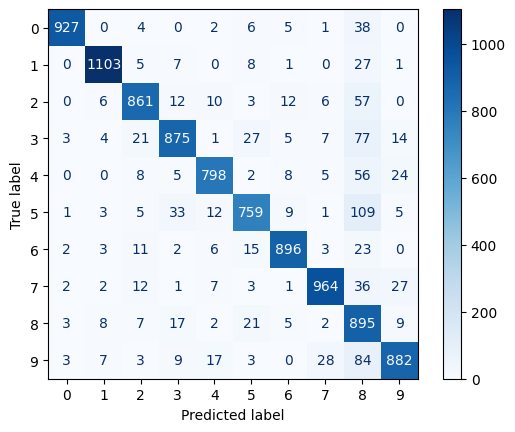

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

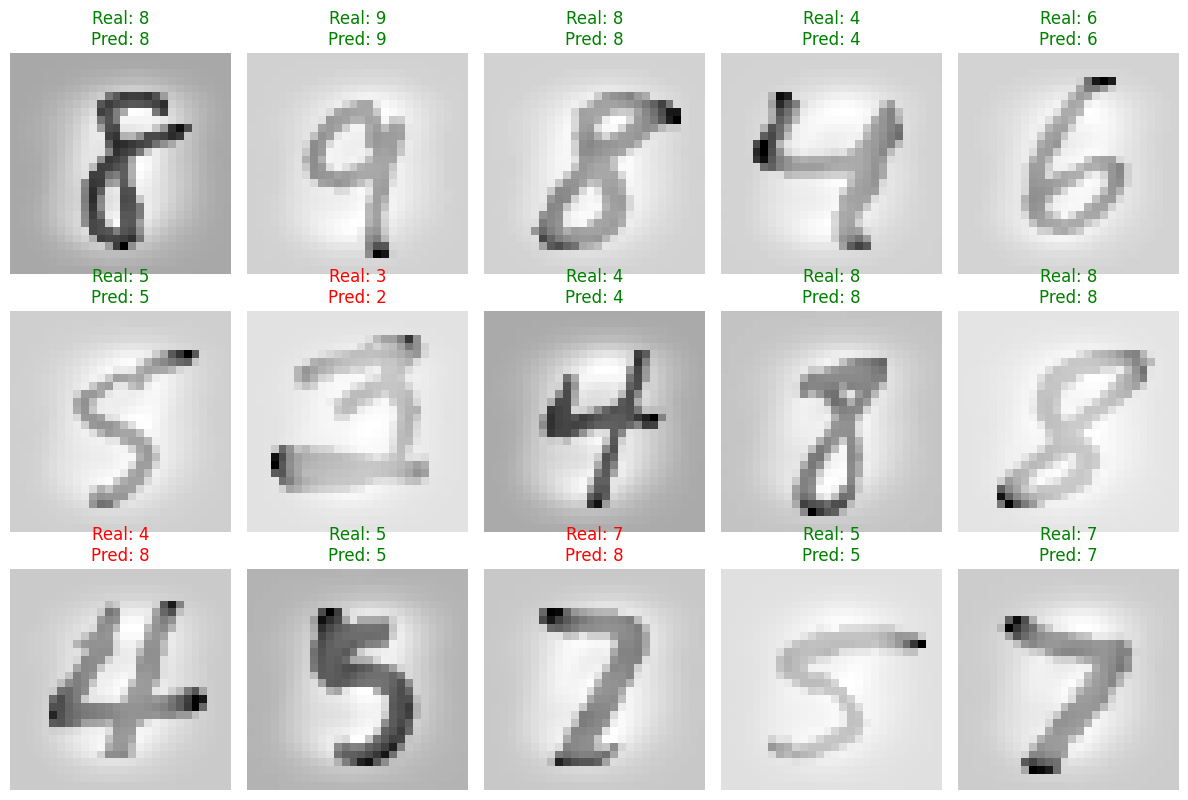

In [22]:
# Plota imagens da classificação
indices = np.random.choice(len(X_test), size=15, replace=False)
sample_images = X_test[indices]
sample_true_labels = y_test[indices]
if clf_is_pca:
    sample_pred_labels = linear_clf.predict(X_test_pca[indices])
else:
    sample_pred_labels = linear_clf.predict(X_test[indices])

plot_predictions(sample_images, sample_true_labels, sample_pred_labels)